# Data Cleaning

In [29]:
import pandas as pd
import re
import string
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction import text
from textblob import TextBlob
df = pd.read_csv("enron_cleaned_data.csv")

In [2]:
# Taking the top 20 'senders' and combining all their email messages into one string
corpus = df[['message', 'From']]
top20 = corpus['From'].value_counts().head(20)
filtered = pd.DataFrame(corpus[corpus.apply(lambda x: x.From in top20.index, axis=1)])
filtered = filtered.reset_index(drop = True)
transposed = filtered.groupby(['From'])['message'].apply(','.join).reset_index()
transposed.head(10)

From  \
0        chris.germany@enron.com   
1    debra.perlingiere@enron.com   
2          drew.fossum@enron.com   
3  enron.announcements@enron.com   
4            eric.bass@enron.com   
5         gerald.nemec@enron.com   
6        jeff.dasovich@enron.com   
7          john.arnold@enron.com   
8           kate.symes@enron.com   
9             kay.mann@enron.com   

                                             message  
0     IT FT Fuel  FT Demand Onshore-Mainline .038...  
1    Please give me a call at your convenience to...  
2  Below are the talking points that I'd propose ...  
3                                                ...  
4   ---------------------- Forwarded by Eric Bass...  
5  Darren, I will be meeting with Sandi in the mo...  
6  Tim/Bob:  Attached is the letter that we sent ...  
7  saw a lot of the bulls sell summer against len...  
8  Did anyone take care of Powerex cuts on Friday...  
9  We are in a loop.  We need a process to deal w...

In [11]:
def clean(text):
    # lowercase, no punctuation, no numbers.
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
clean_text = lambda x: clean(x)

In [12]:
def lc_remove(text): 
    return ' '.join(word for word in text.split() if len(word) in range(4,11))

In [13]:
data_clean = pd.DataFrame(transposed.message.apply(clean_text))

In [14]:
for i in range (20):
    data_clean.iloc[i]['message'] = lc_remove(data_clean.iloc[i]['message'])

In [15]:
data_clean.iloc[0, 0]

'fuel demand rates include griyou really dont care about back doing went florida with brother last week spent days airshow days disney enjoyed both very much that first disney trip pretty cool need with chic next time though hodge trading cgas number correct again dude behave yourself girl veselack joni chris germany subject hows going hows your back easter come down tcogulf meeting have blessing boss first doing pool screen says john hodge really nice john cant remember last name from still enron have number been given order start finding appal what thought would give javins call hope well national energy group other company referenced herein that uses name logo same company pacific electric company regulated california utility neither national energy group these other referenced companies regulated california public utilities commission customers pacific electric company have products from these companies order continue receive quality regulated services from utility show tatoo need 

In [16]:
data_clean.to_pickle("corpus.pkl")

In [17]:
data = pd.read_pickle('corpus.pkl')

In [18]:
data['From'] = transposed['From']
data.to_pickle("corpus.pkl")

# Count Vectorization, World Clouds

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data.message)
doc_term = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
doc_term.index = data.index

In [20]:
doc_term.to_pickle("dtm.pkl")
transposed.to_pickle("transposed.pkl")

In [21]:
data = pd.read_pickle('dtm.pkl')
data = data.transpose()
data.head()

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
aaaaaaaa     0   0   0   0   0   0   0   0   4   0   0   0   0   0   0   0   
aaaenerfax   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
aaahhh       0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
aabe         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
aabout       0   0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   

            16  17  18  19  
aaaaaaaa     0   0   0   0  
aaaenerfax   0   0   0   8  
aaahhh       0   2   0   0  
aabe         4   0   0   0  
aabout       0   0   0   0

In [22]:
## View top 30 words for each person
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))
top_dict

{0: [('chris', 11203),
  ('subject', 9478),
  ('deal', 5931),
  ('germany', 4180),
  ('forwarded', 3551),
  ('know', 3515),
  ('enron', 3044),
  ('need', 2968),
  ('contract', 2926),
  ('thanks', 2912),
  ('sent', 2867),
  ('message', 2829),
  ('capacity', 2517),
  ('original', 2461),
  ('just', 2361),
  ('storage', 2034),
  ('scott', 2009),
  ('energy', 1951),
  ('like', 1869),
  ('production', 1845),
  ('email', 1800),
  ('volume', 1718),
  ('april', 1642),
  ('company', 1626),
  ('demand', 1623),
  ('dont', 1602),
  ('deals', 1558),
  ('think', 1527),
  ('going', 1429),
  ('power', 1427)],
 1: [('debra', 5292),
  ('enron', 4635),
  ('north', 4039),
  ('america', 4032),
  ('houston', 3934),
  ('texas', 3925),
  ('street', 3877),
  ('smith', 3872),
  ('corp', 3753),
  ('phone', 3664),
  ('legal', 3422),
  ('department', 2930),
  ('agreement', 1380),
  ('thanks', 1187),
  ('subject', 1187),
  ('attached', 1039),
  ('master', 1027),
  ('sent', 1019),
  ('contract', 970),
  ('gisb', 898)

In [25]:
words = []
for address in data.columns:
    top = [word for (word, count) in top_dict[address]]
    for t in top:
        words.append(t)

In [24]:
add_stop_words = [word for word, count in Counter(words).most_common() if count > 10]
add_stop_words.append('kay')
add_stop_words.append('chris')
add_stop_words.append('susan')
add_stop_words.append('sally')
add_stop_words.append('tana')
add_stop_words.append('gerald')
add_stop_words.append('john')
add_stop_words.append('vince')
add_stop_words.append('mark')
add_stop_words.append('drew')
add_stop_words.append('arnold')
add_stop_words.append('sara')
add_stop_words.append('eric')
add_stop_words.append('bass')
add_stop_words.append('jeff')
add_stop_words.append('kate')
add_stop_words.append('matthew')
add_stop_words.append('lenhart')
add_stop_words.append('kaminski')

In [273]:
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

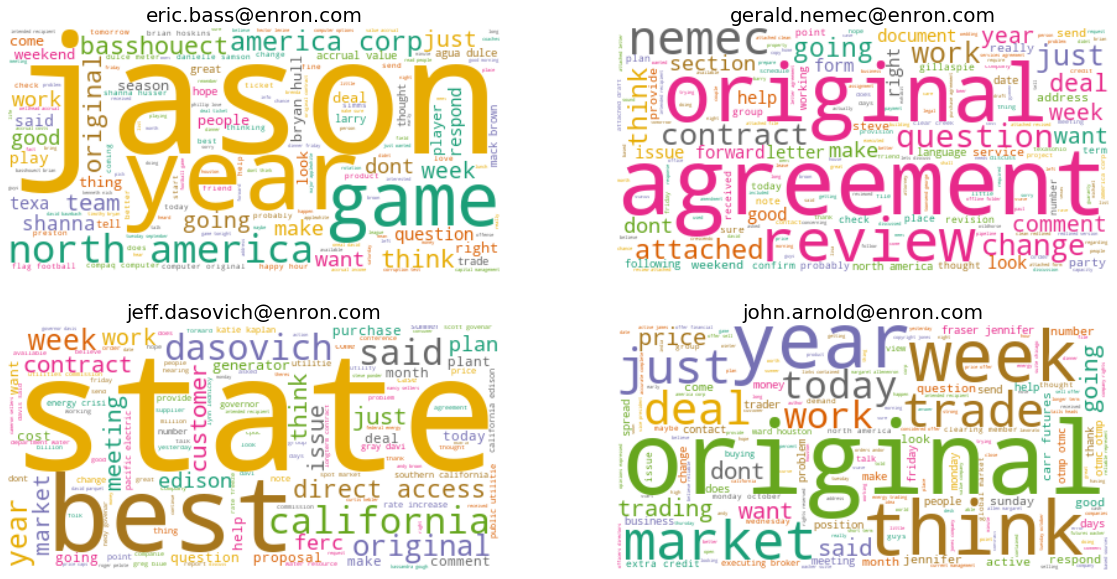

In [274]:
import matplotlib.pyplot as plt

# plt.rcParams['figure.figsize'] = [30,30]
plt.figure(figsize=(20,10))
names = transposed['From'].values

# Create subplots for each comedian
i = 4
for index, From in enumerate(data.columns[i:i+4]):
    wc.generate(data_clean.message[From])
    plt.subplot(2, 2, index + 1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(names[i + index], fontsize = 20)    
plt.show()

# Sentiment Analysis

In [27]:
sent_df = pd.read_pickle("corpus.pkl")
sent_df

message  \
0   fuel demand rates include griyou really dont c...   
1   please give call your discuss debra enron nort...   
2   below talking points that propose stan then ha...   
3   annual deferral program enrollment process und...   
4   forwarded eric basshouect from larry hunter er...   
5   darren will meeting with sandi morning downloa...   
6   timbob attached letter that sent lynch explain...   
7   bulls sell summer against length front mitigat...   
8   anyone take care powerex cuts friday entered s...   
9   loop need process deal with this ideas welcome...   
10  stacey mark this afternoon discuss december co...   
11  that supposed funny forwarded matthew subject ...   
12  earlier this week enron global technology anno...   
13  monica doing wellthanks asking have removed fr...   
14  backup seat backup computer have been assigned...   
15  susan please send foregoing list richard thank...   
16  think need some clear indication that with hog...   
17  forwarded susan enron capital trade resources ...   
18  tana jones office will return thursday novembe...   
19  sally vincerick read your memo regarding globa...   

                             From  
0         chris.germany@enron.com  
1     debra.perlingiere@enron.com  
2           drew.fossum@enron.com  
3   enron.announcements@enron.com  
4             eric.bass@enron.com  
5          gerald.nemec@enron.com  
6         jeff.dasovich@enron.com  
7           john.arnold@enron.com  
8            kate.symes@enron.com  
9              kay.mann@enron.com  
10          mark.taylor@enron.com  
11      matthew.lenhart@enron.com  
12           no.address@enron.com  
13           pete.davis@enron.com  
14           sally.beck@enron.com  
15      sara.shackleton@enron.com  
16          steven.kean@enron.com  
17          susan.scott@enron.com  
18           tana.jones@enron.com  
19       vince.kaminski@enron.com

In [34]:
polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

sent_df['polarity'] = sent_df['message'].apply(polarity)
sent_df['subjectivity'] = sent_df['message'].apply(subjectiviy)
sent_df

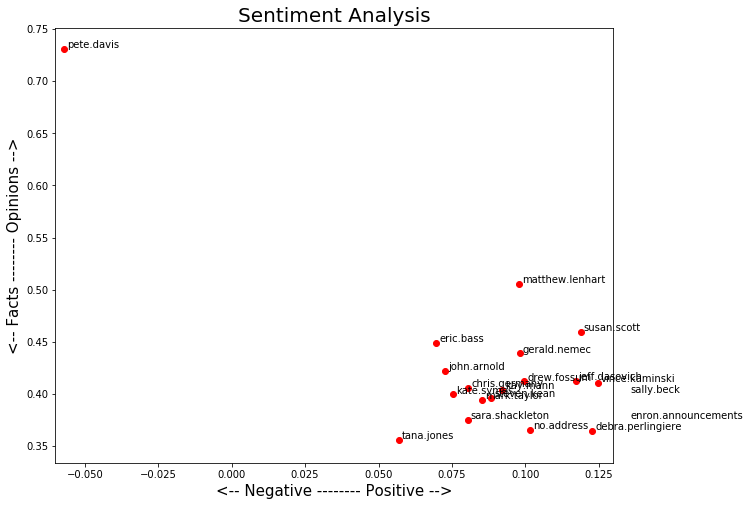

In [185]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, From in enumerate(sent_df.index):
    x = sent_df.polarity.loc[From]
    y = sent_df.subjectivity.loc[From]
    plt.scatter(x, y, color='red')
    at = sent_df['From'][index].find('@')
    plt.text(x+.001, y+.001, sent_df['From'][index][0:at], fontsize=10)
    plt.xlim(-.06, .13) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

## What's up with Pete Davis?

Here is the all the text sent by Pete Davis

In [32]:
sent_df.loc[13, 'message']

'monica doing wellthanks asking have removed from list what group pete original message from causholli monika sent thursday october davis pete subject start date hourahead hour codesite pete remove from list thanks monika causholli original message from davis pete sent thursday october davis pete meyers bert williams bill dean craig linder eric solberg geir symes kate harasin leaf causholli monika guzman mark davis pete slinger ryan subject start date hourahead hour codesite start date hourahead hour ancillary schedules awarded variances detected variances detected energy schedule messages parsing file final error retrieving hourahead price data process continuing energy schedule variance found table details hour preferred final transtype final scid ectrt mkttype transdate tiepoint interchgid engytype firm start date hourahead hour ancillary schedules awarded variances detected variances detected energy schedule messages parsing file final error retrieving hourahead price data process 

Now let's look at his top words

In [35]:
top_dict.get(13)

[('final', 27915),
 ('error', 27125),
 ('database', 24058),
 ('schedule', 17351),
 ('hour', 17104),
 ('alias', 14634),
 ('detected', 11772),
 ('variances', 11772),
 ('hourahead', 11389),
 ('operation', 11194),
 ('transtype', 10384),
 ('mkttype', 10384),
 ('scid', 10194),
 ('transdate', 10190),
 ('date', 9133),
 ('file', 8959),
 ('occurred', 8752),
 ('initialize', 8750),
 ('engine', 8750),
 ('attempting', 8750),
 ('borland', 8750),
 ('preferred', 8571),
 ('details', 8256),
 ('messages', 8245),
 ('parsing', 8174),
 ('unknown', 8146),
 ('ancillary', 7405),
 ('awarded', 7402),
 ('schedules', 7399),
 ('start', 6989)]